In [28]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2022-03-27 13:51:14.398184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 13:51:14.398606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2022-03-27 13:51:14.398672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-27 13:51:14.398753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-27 13:51:14.398805: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-03-27 13:51:14.398850: I tensorflow/stream_execut

In [29]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


In [30]:
# import the training data into df 
import pandas as pd 

df = pd.read_csv('CSVFiles/training-data-positive-and-negative-sentiment-english.csv')
df = df.drop('Unnamed: 0',axis=1)
df.shape

(59500, 3)

Text(0.5, 0, 'Sentiment Score')

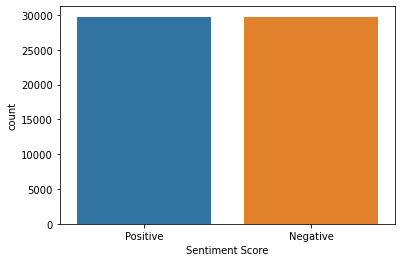

In [31]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.countplot(x=df.Sentiment)
plt.xlabel('Sentiment Score')

In [38]:
# !pip3 install pytorch_pretrained_bert 
from transformers import BertTokenizer

In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [45]:
# some regex to clean the data before passing it to BERT tokenizer  
import re 
df = df.replace(to_replace='https?:\/\/\S+', value='', regex=True) # remove https urls 
df = df.replace(to_replace="www\.[a-z]?\.?(com)+|[a-z]+\.(com)", value='', regex=True) # remove www urls 
df = df.replace(to_replace="\[video\]", value='', regex=True) # remove videos that got replaced with [video]
df = df.replace(to_replace='{link}', value='', regex=True) # remove links 
df = df.replace(to_replace='&[a-z]+;', value='', regex=True) # remove HTML embedded characters
df = df.replace(to_replace='@[^ ]+', value='', regex=True) # remove @usernames 
df = df.replace({'Sentiment': {'Negative':int(0), 'Neutral':int(1), 'Positive':int(2)}})  

# some sample output 
tweets = df.text.values 
labels = df.Sentiment.values 
import numpy as np
labels = np.array(labels)

print(' Original: ', tweets[0])
print('Tokenized: ', tokenizer.tokenize(tweets[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 2019 
Tokenized:  ['e', 'app', '##ena', 'usc', '##ito', 'un', 'nu', '##ovo', 'video', '!', 'les', 'crypt', '##omo', '##nna', '##ies', 'qui', 'pu', '##lver', '##isen', '##t', 'bit', '##co', '##in', 'en', '2019']
Token IDs:  [1041, 10439, 8189, 15529, 9956, 4895, 16371, 16059, 2678, 999, 4649, 19888, 19506, 9516, 3111, 21864, 16405, 26229, 28992, 2102, 2978, 3597, 2378, 4372, 10476]


In [46]:
# now we can perform tokenization 
input_ids = [] 
attention_masks = [] 

for i in range(len(tweets)):
    encoded_dict = tokenizer.encode_plus(
                        str(tweets[i]),                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # add encoded sentence to list 
    input_ids.append(encoded_dict['input_ids'])
    # add attention masks to list 
    attention_masks.append(encoded_dict['attention_mask'])
    
#convert the lists into tensors 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

/home/phil81/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 2019 
Token IDs: tensor([  101,  1041, 10439,  8189, 15529,  9956,  4895, 16371, 16059,  2678,
          999,  4649, 19888, 19506,  9516,  3111, 21864, 16405, 26229, 28992,
         2102,  2978,  3597,  2378,  4372, 10476,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [54]:
train_data = df[0:59000]
test_data = df[59000:]

train_texts = train_data['text'].values
train_labels = train_data['Sentiment'].values

test_texts = test_data['text'].values
test_labels = test_data['Sentiment'].values

test_masks = attention_masks[:59000]
train_masks = attention_masks[59000:]

train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_texts))

train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

train_y = np.array(train_labels)==1
test_y = np.array(test_labels)==1